In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob


# Load image's path and mask's path

In [2]:
image_files = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_files.append(i.replace('_mask',''))

In [3]:

def load_label(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(256,256))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)
    return np.expand_dims(image/255.0,axis=-1)


# Data Visualization

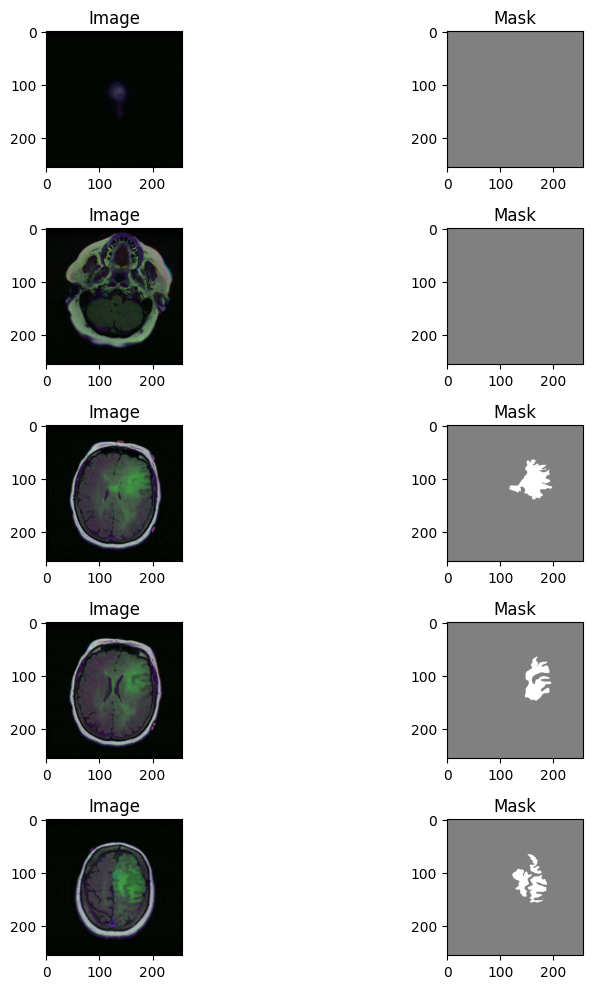

In [4]:
# Let's plot some samples
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows):
    img_path = image_files[i]
    msk_path = mask_files[i]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    msk = cv2.imread(msk_path)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(msk, alpha=0.5)

    axes[i, 0].set_title('Image')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()


**Tạo contour ảnh mask tạo dữ liệu cho model YOLO**

In [5]:
def mask_to_yolo_contours(mask, annotation_file):
    mask = mask.replace('.tif', '_mask.tif')
#     print(mask)
    open(annotation_file, "w").close()
    binary_mask = load_label(mask)
    
    binary_mask = binary_mask.reshape(256, 256)
    binary_mask = binary_mask.astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     print(contours)
    for cnt in contours:
        st = '0 '
        for i in cnt:
            st += str(i[0][0]/256) + ' ' + str(i[0][1]/256) + ' '
        with open(annotation_file, 'a') as ann_file:
            ann_file.write(st + '\n')

In [6]:
IMAGES = "images/"
LABELS = "labels/"
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)
os.makedirs(IMAGES+"test", exist_ok=True)
os.makedirs(LABELS+"test", exist_ok=True)

In [7]:
df = pd.DataFrame(data={"image_path": image_files, 'mask_path' : mask_files})
df.head()

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

# Create data frame and split data on train set, validation set and test set

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_valid_test = train_test_split(df,test_size=0.2,random_state=42)
df_valid, df_test = train_test_split(df_valid_test,test_size=0.5,random_state=42)

files = list(df.image_path.unique())
files_train,files_valid_test = train_test_split(files,test_size=0.2,random_state=42)
files_valid,files_test = train_test_split(files_valid_test,test_size=0.5,random_state=42)

len(files_train),len(files_valid), len(files_test)

(3143, 393, 393)

In [9]:
import shutil

train_filename = set(files_train)
valid_filename = set(files_valid)
test_filename = set(files_test)
for i,file in enumerate(files):
    if file in train_filename:
        shutil.copy(file, IMAGES+"train")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "train/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)
        
    elif file in valid_filename:
        shutil.copy(file, IMAGES+"valid")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "valid/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)
            
    elif file in test_filename:
        shutil.copy(file, IMAGES+"test")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "test/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)

In [10]:
%%writefile dataset.yaml
# Path
train: /kaggle/working/images/train
val: /kaggle/working/images/valid

# Classes
nc: 1
names: ['Tumor']
    
# # Data augmentation
# augment:
#   mosaic: 1.0  # áp dụng phương pháp ghép ảnh (mosaic) với xác suất 1.0
#   flipud: 0.5  # lật ảnh theo chiều dọc với xác suất 0.5
#   shuffle: True  # trộn dữ liệu huấn luyện trước khi mỗi epoch
#   center_crop: 0.5  # cắt ảnh theo trung tâm với xác suất 0.5
#   scale: 0.5  # thu phóng ảnh với tỉ lệ ngẫu nhiên trong khoảng từ 0.5 đến 2.0
#   rotate: 0.5  # xoay ảnh ngẫu nhiên với góc xoay trong khoảng từ -10 đến 10 độ
#   hsv: 0.5  # điều chỉnh giá trị Hue, Saturation và Value của ảnh
#   translate: 0.5  # dịch chuyển ảnh theo chiều ngang và dọc với độ lệch tối đa 10%
#   shear: 0.5  # cắt ảnh theo hướng ngẫu nhiên với góc cắt trong khoảng từ -10 đến 10 độ

Writing dataset.yaml


In [11]:
!pip install -U ultralytics
!pip install -U ipywidgets
!pip install -U ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 728.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 kB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 825.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipyw

In [12]:
from ultralytics import YOLO

model = YOLO('yolov9e-seg.pt')

model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch=64, imgsz=256)


100%|██████████| 117M/117M [00:00<00:00, 270MB/s] 


Ultralytics YOLOv8.2.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=/kaggle/working/dataset.yaml, epochs=50, time=None, patience=100, batch=64, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]
2024-05-07 08:51:52.525066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 08:51:52.525208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 08:51:52.644862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  ultralytics.nn.modules.block.Silence         []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.42.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 69.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 3143 images, 2047 backgrounds, 0 corrupt: 100%|██████████| 3143/3143 [00:04<00:00, 735.79it/s]


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/valid... 393 images, 261 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<00:00, 738.07it/s]

val: New cache created: /kaggle/working/labels/valid.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      15.4G      1.804      3.407      6.109      1.536          5        256: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        393        155          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      15.1G      1.763      2.946      1.733      1.526          6        256: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        393        155          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      15.1G      1.808      3.012      1.716      1.571          3        256: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        393        155          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.1G      1.701      2.741      1.518      1.475          5        256: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.797      0.329      0.337      0.169      0.797      0.329      0.338      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      14.6G      1.609       2.57      1.353      1.426          5        256: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        393        155      0.185     0.0323     0.0228     0.0173      0.222     0.0387     0.0231     0.0122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      14.6G      1.532      2.499      1.266       1.38          9        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.381     0.0774     0.0573     0.0339      0.381     0.0774      0.058     0.0283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      15.1G      1.471      2.435      1.216      1.354          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        393        155       0.47      0.232      0.213      0.114      0.473      0.232      0.204     0.0812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      15.1G      1.448      2.347      1.147      1.319          5        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.724      0.574      0.612        0.4      0.798      0.529      0.592      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      15.1G      1.439      2.367      1.128      1.316          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        393        155      0.838      0.606      0.676      0.377      0.817      0.594      0.641      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      15.1G      1.412      2.254      1.057      1.316          5        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        393        155      0.779      0.529      0.607        0.4      0.769      0.523      0.596      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      15.1G      1.372      2.312      1.031      1.274          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.817      0.561      0.656      0.391      0.887      0.558      0.645      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      15.1G      1.354      2.198       0.99       1.25          8        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.874      0.627       0.69      0.436      0.845      0.596      0.646      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      15.1G      1.301      2.184     0.9687      1.244         10        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.864      0.573      0.672      0.441      0.844       0.56      0.652       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      15.1G      1.262      2.145     0.9249      1.224          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.841        0.6      0.682      0.423      0.821      0.587      0.663      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      14.6G      1.274      2.094     0.8852      1.242          3        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.879      0.639      0.729       0.48      0.852      0.619      0.699      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      15.1G      1.258      2.039     0.9009      1.219          8        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        393        155      0.907      0.658      0.718      0.443      0.862      0.626      0.673      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      15.1G       1.22      2.138     0.8694      1.211          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.849       0.58      0.657      0.461      0.868      0.593      0.656      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      15.1G      1.198      2.077      0.846      1.183          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        393        155       0.84      0.645      0.716      0.444      0.824      0.633      0.692      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      15.1G      1.195      2.071     0.8532      1.204          1        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all        393        155      0.845      0.631      0.671      0.453       0.84       0.61       0.65      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      15.1G      1.208      1.999      0.821      1.186          5        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.879      0.658      0.746       0.48      0.861      0.626       0.69      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      14.6G      1.183      2.007     0.8059      1.176          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.853      0.665      0.723      0.484      0.806      0.632      0.674      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      15.1G      1.177      1.997     0.7795       1.16          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        393        155      0.795      0.649      0.676      0.468      0.795      0.651      0.656      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      15.1G      1.135      1.909     0.7605      1.161          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        393        155       0.83      0.671      0.729      0.489      0.818      0.632      0.681      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      15.1G      1.117      1.835     0.7384      1.131          0        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        393        155      0.873      0.652      0.731      0.501      0.847      0.632      0.698       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.1G      1.129      1.939      0.758      1.153          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        393        155        0.9      0.694      0.768      0.536      0.892      0.691      0.747      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      15.1G      1.109      1.902      0.739      1.155          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.881      0.714       0.78       0.52      0.865      0.701      0.743      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      15.1G      1.135      1.902     0.7272      1.143          7        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        393        155      0.881      0.671      0.749      0.516      0.872      0.665      0.742      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      15.1G      1.138      1.884      0.716      1.171          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        393        155      0.869      0.697       0.75      0.539      0.886      0.665      0.725      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      15.1G      1.088      1.849     0.7084      1.128          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.932      0.703      0.785      0.551       0.91      0.697       0.75      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.1G      1.087      1.832     0.7024       1.12          8        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.934      0.697       0.77      0.528      0.938      0.681      0.741      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      15.1G      1.072      1.812     0.7062        1.1          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        393        155      0.909      0.705      0.771      0.534      0.892      0.692      0.753      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.1G      1.081      1.903     0.6969      1.123          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        393        155      0.918      0.729      0.789      0.547      0.917      0.703      0.763      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      15.1G      1.039      1.788      0.661      1.097          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.927      0.671      0.765      0.517       0.91      0.658      0.732       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      15.1G      1.008      1.767     0.6422       1.09          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        393        155      0.923      0.698      0.774      0.539      0.915      0.691      0.764       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      15.1G      1.036      1.786     0.6474      1.099          7        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.917      0.715      0.791       0.55      0.912      0.703      0.773      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      15.1G      1.021      1.735     0.6561      1.088          3        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.915      0.703      0.779       0.54      0.928      0.668      0.753      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      15.1G      1.009      1.772     0.6482       1.07          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.909      0.723      0.787       0.55      0.916        0.7      0.765      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      15.1G     0.9985      1.719     0.6162      1.074          3        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        393        155      0.901      0.716      0.782      0.548      0.924      0.702      0.767      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      14.6G      0.975      1.672     0.5961      1.091          3        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        393        155      0.905      0.735      0.811       0.55      0.897      0.729      0.795      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      15.1G     0.9832      1.735     0.6066      1.087          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        393        155      0.939       0.71      0.796      0.565      0.948      0.702      0.779      0.487


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      15.1G      0.957      1.812     0.5941      1.123          1        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        393        155      0.945      0.723      0.809      0.578      0.937      0.716      0.782      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      14.6G     0.9809      1.766     0.6105      1.147          6        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.958      0.729      0.807       0.56      0.951      0.716      0.791       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      15.1G     0.9538      1.688     0.5603      1.116          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.942      0.728      0.804      0.572      0.923      0.698      0.773      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      15.1G     0.9248      1.722     0.5616        1.1          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155       0.95       0.71      0.802      0.569       0.95       0.71        0.8      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      15.1G     0.9193      1.668     0.5369      1.085          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.958      0.741      0.832      0.574       0.95      0.735      0.811      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      15.1G     0.9329      1.625     0.5508      1.125          1        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.948      0.735       0.83      0.586      0.948      0.735      0.818      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      15.1G     0.8984      1.658     0.5301      1.095          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.955      0.729      0.827      0.584      0.938      0.716      0.798      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      15.1G     0.8941      1.639     0.5234      1.081          5        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        393        155      0.954      0.723      0.829      0.581      0.945      0.716      0.816      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      14.6G     0.8539      1.599     0.4992      1.054          2        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.942      0.732      0.831       0.58      0.933      0.723      0.818      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      15.1G     0.8691      1.624     0.5024       1.07          4        256: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        393        155      0.927      0.742      0.831      0.583      0.951       0.71      0.805       0.51



50 epochs completed in 1.009 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 121.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 121.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9e-seg summary (fused): 714 layers, 59682451 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        393        155      0.927      0.742      0.831      0.583      0.938      0.735      0.806      0.511
Speed: 0.0ms preprocess, 7.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f90322a9450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

**EVALUATING THE MODEL USING TEST DATA**

In [13]:
%%writefile dataset_test.yaml
# Path
train: /kaggle/working/images/train
val: /kaggle/working/images/test

# Classes
nc: 1
names: ['Tumor']

Writing dataset_test.yaml


In [14]:
!yolo val model='/kaggle/working/runs/segment/train/weights/best.pt' data='/kaggle/working/dataset_test.yaml' batch=64 imgsz=256

Ultralytics YOLOv8.2.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9e-seg summary (fused): 714 layers, 59682451 parameters, 0 gradients, 244.4 GFLOPs
val: Scanning /kaggle/working/labels/test... 393 images, 248 backgrounds, 0 corr
val: New cache created: /kaggle/working/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        393        161      0.913      0.795      0.851      0.611      0.906      0.789      0.848      0.557
Speed: 0.5ms preprocess, 14.1ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [15]:
!zip -r training.zip /kaggle/working/runs/segment/train

  adding: kaggle/working/runs/segment/train/ (stored 0%)
  adding: kaggle/working/runs/segment/train/events.out.tfevents.1715071925.16ba69b5922c.34.0 (deflated 94%)
  adding: kaggle/working/runs/segment/train/confusion_matrix.png (deflated 41%)
  adding: kaggle/working/runs/segment/train/val_batch2_labels.jpg (deflated 20%)
  adding: kaggle/working/runs/segment/train/val_batch1_labels.jpg (deflated 22%)
  adding: kaggle/working/runs/segment/train/train_batch1.jpg (deflated 8%)
  adding: kaggle/working/runs/segment/train/MaskR_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/train/BoxPR_curve.png (deflated 23%)
  adding: kaggle/working/runs/segment/train/val_batch0_pred.jpg (deflated 22%)
  adding: kaggle/working/runs/segment/train/train_batch2.jpg (deflated 8%)
  adding: kaggle/working/runs/segment/train/BoxP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/train/labels_correlogram.jpg (deflated 43%)
  adding: kaggle/working/runs/segment/train/train_batch200

In [16]:
!zip -r testing.zip /kaggle/working/runs/segment/val

  adding: kaggle/working/runs/segment/val/ (stored 0%)
  adding: kaggle/working/runs/segment/val/confusion_matrix.png (deflated 39%)
  adding: kaggle/working/runs/segment/val/val_batch2_labels.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/val_batch1_labels.jpg (deflated 17%)
  adding: kaggle/working/runs/segment/val/MaskR_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/val/BoxPR_curve.png (deflated 24%)
  adding: kaggle/working/runs/segment/val/val_batch0_pred.jpg (deflated 19%)
  adding: kaggle/working/runs/segment/val/BoxP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/val/val_batch0_labels.jpg (deflated 19%)
  adding: kaggle/working/runs/segment/val/MaskP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/val/val_batch2_pred.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/runs/segment/val/BoxF1_curve.png (deflated 16%)
  adding: kaggle/workin

In [17]:
test = model("/kaggle/working/images/test",save=True, conf=0.5, iou=0.5)


image 1/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_1.tif: 256x256 (no detections), 43.0ms
image 2/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_13.tif: 256x256 1 Tumor, 35.4ms
image 3/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_17.tif: 256x256 1 Tumor, 31.8ms
image 4/393 /kaggle/working/images/test/TCGA_CS_4942_19970222_2.tif: 256x256 (no detections), 31.0ms
image 5/393 /kaggle/working/images/test/TCGA_CS_4942_19970222_3.tif: 256x256 (no detections), 30.8ms
image 6/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_12.tif: 256x256 (no detections), 30.8ms
image 7/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_15.tif: 256x256 1 Tumor, 29.0ms
image 8/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_7.tif: 256x256 (no detections), 28.6ms
image 9/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_8.tif: 256x256 (no detections), 29.0ms
image 10/393 /kaggle/working/images/test/TCGA_CS_4944_20010208_11.tif: 256x256 1 Tumor, 28.8ms
image 11/393 /k

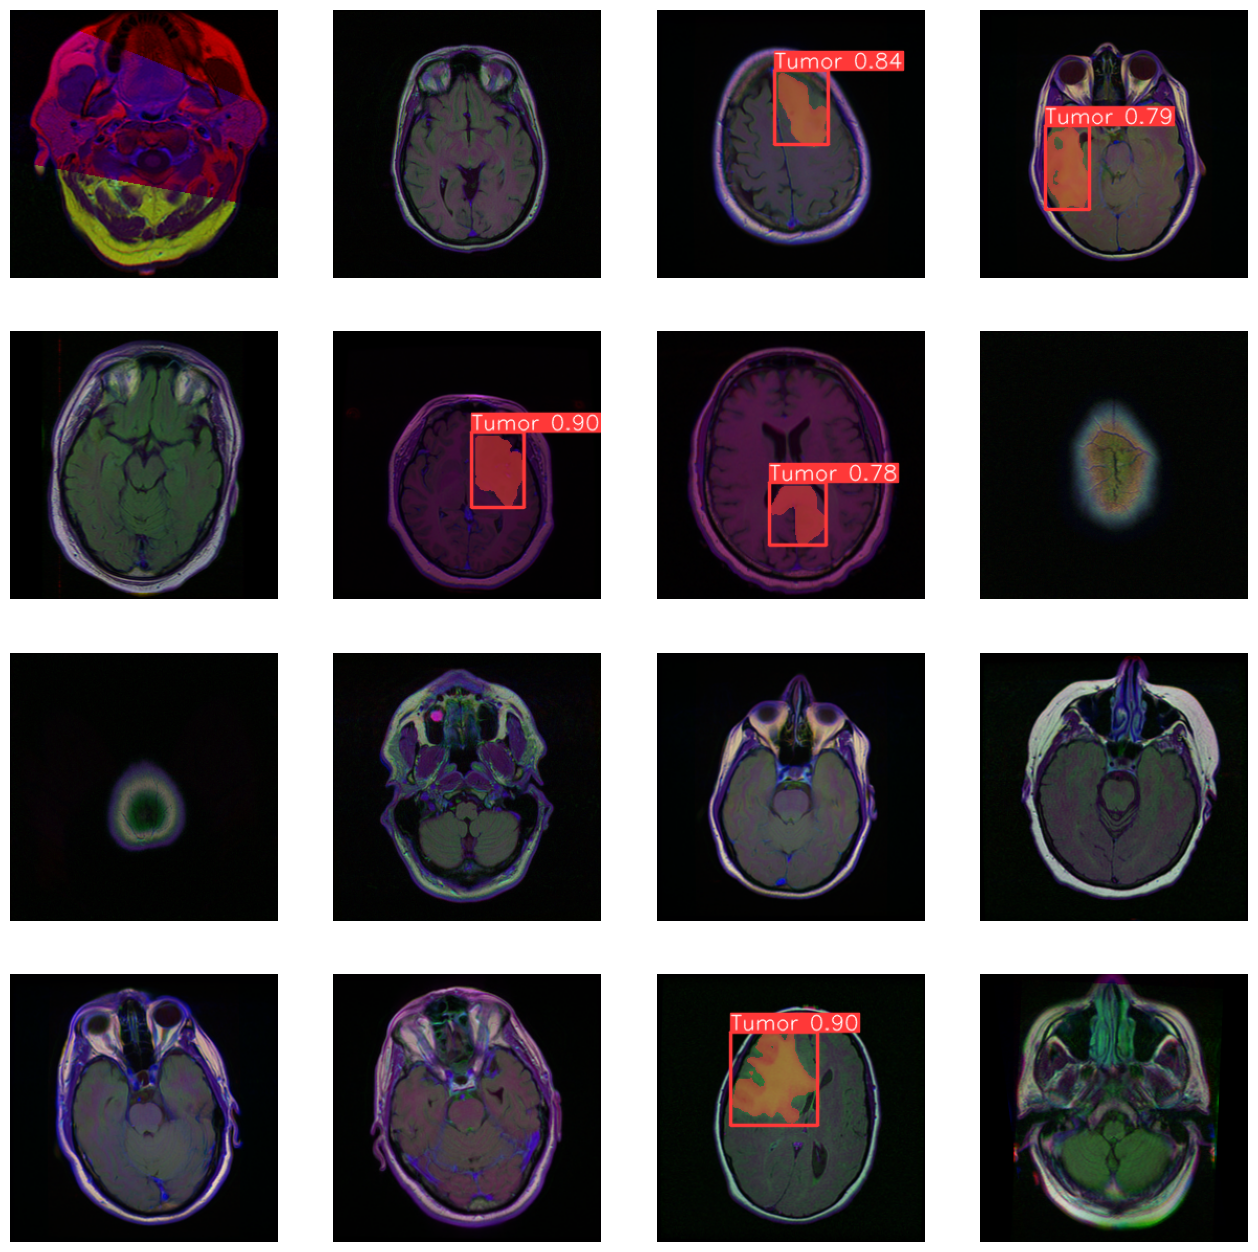

In [19]:
import glob
from PIL import Image
files = glob.glob("/kaggle/working/runs/segment/train2/*")

fig = plt.figure(figsize=(16, 16))
for i in range(1,17, 1):
    fig.add_subplot(4, 4, i)
    img = Image.open(files[i])
    plt.imshow(img)    
    plt.axis(False)
plt.show()

In [20]:
!zip -r runs.zip /kaggle/working/runs

  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/segment/ (stored 0%)
  adding: kaggle/working/runs/segment/val/ (stored 0%)
  adding: kaggle/working/runs/segment/val/confusion_matrix.png (deflated 39%)
  adding: kaggle/working/runs/segment/val/val_batch2_labels.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/val_batch1_labels.jpg (deflated 17%)
  adding: kaggle/working/runs/segment/val/MaskR_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/val/BoxPR_curve.png (deflated 24%)
  adding: kaggle/working/runs/segment/val/val_batch0_pred.jpg (deflated 19%)
  adding: kaggle/working/runs/segment/val/BoxP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/val/val_batch0_labels.jpg (deflated 19%)
  adding: kaggle/working/runs/segment/val/MaskP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/val/val_batch2_pred.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/confusion_matrix_normalized.png (deflated 38%)
  


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_29.tif: 256x256 2 Tumors, 35.9ms
Speed: 0.6ms preprocess, 35.9ms inference, 3.3ms postprocess per image at shape (1, 3, 256, 256)


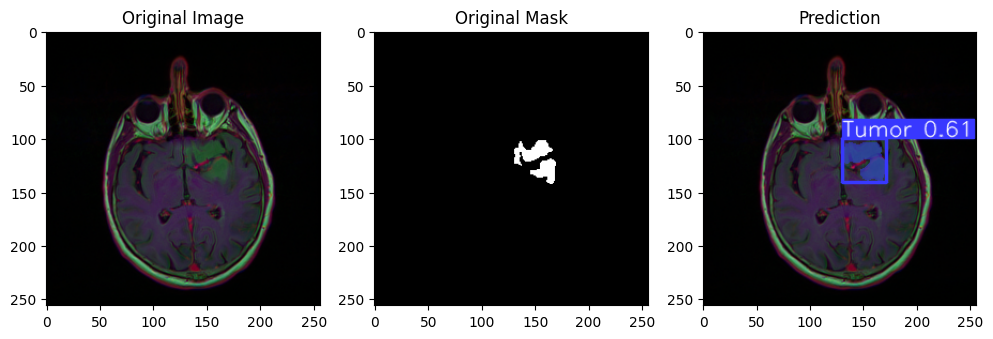


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40.tif: 256x256 1 Tumor, 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


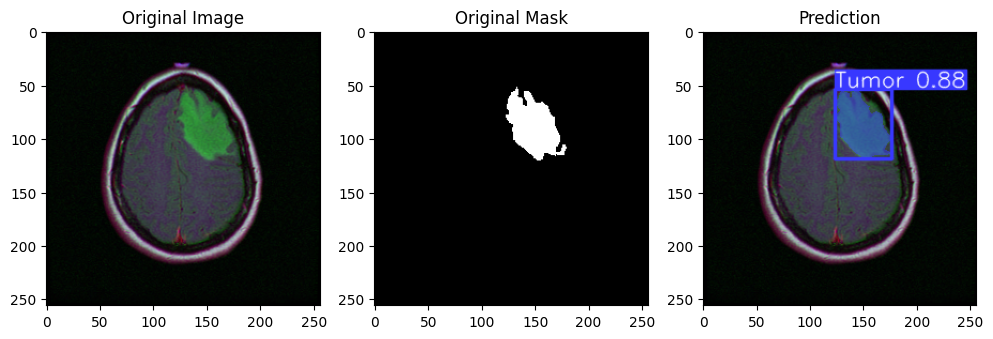


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_31.tif: 256x256 (no detections), 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


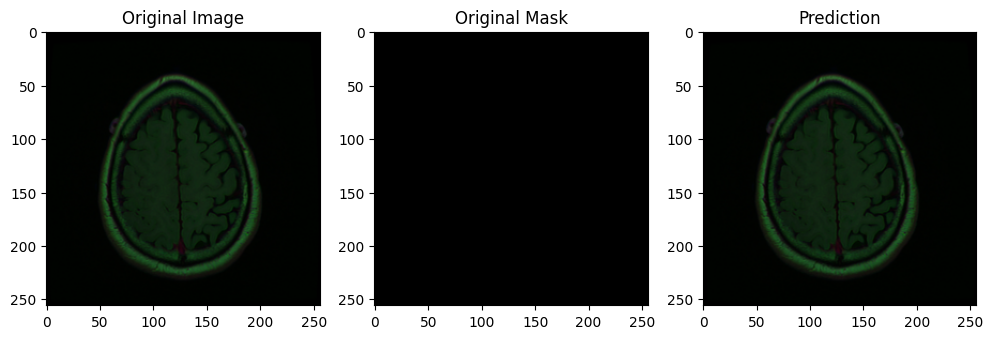


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_3.tif: 256x256 (no detections), 35.7ms
Speed: 0.6ms preprocess, 35.7ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


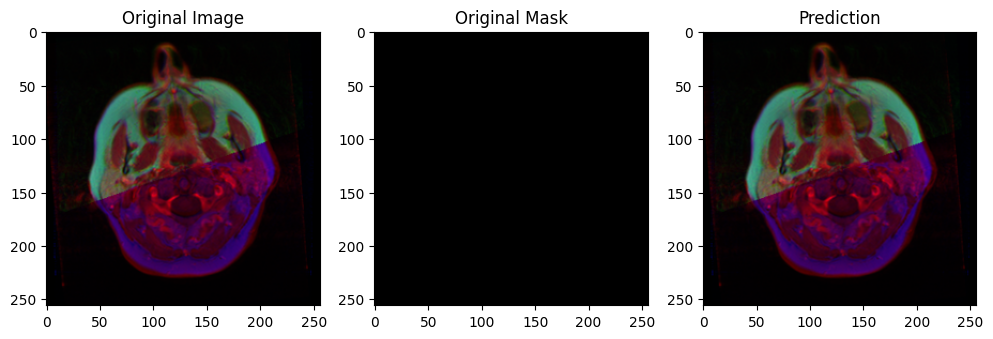


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_10.tif: 256x256 (no detections), 35.6ms
Speed: 0.6ms preprocess, 35.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


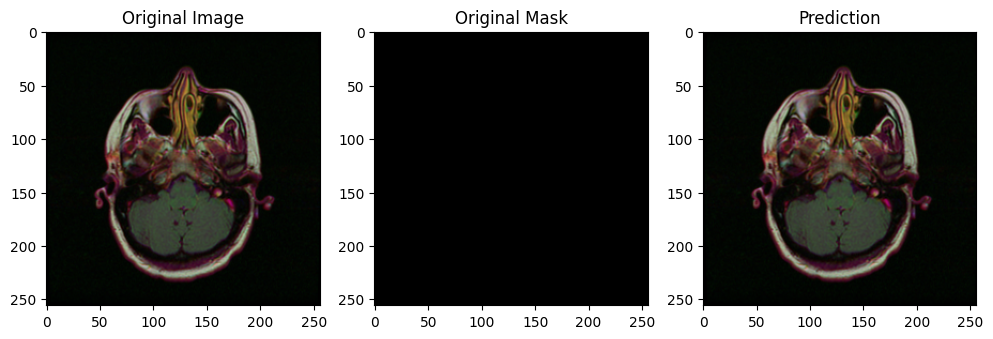


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_55.tif: 256x256 (no detections), 35.4ms
Speed: 0.7ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


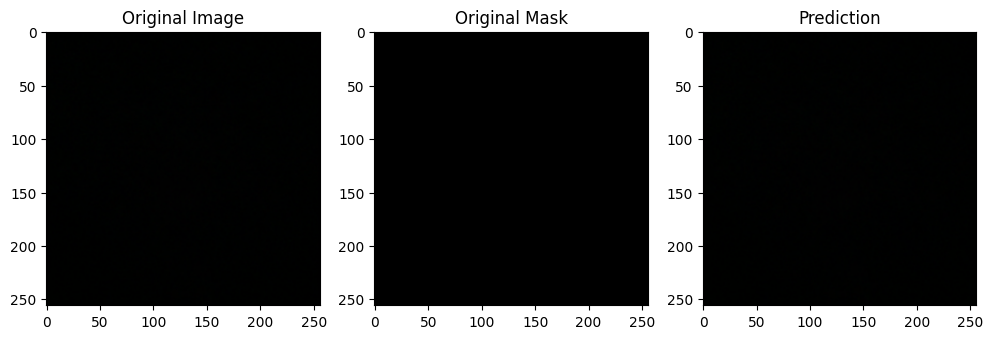


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_36.tif: 256x256 1 Tumor, 37.2ms
Speed: 0.6ms preprocess, 37.2ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


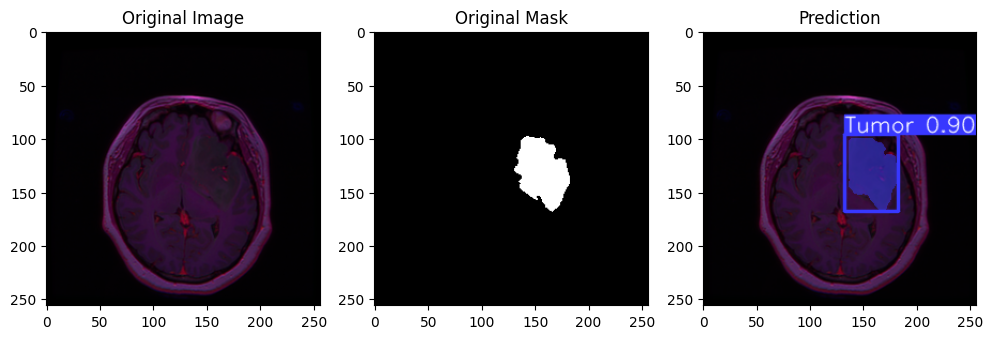


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


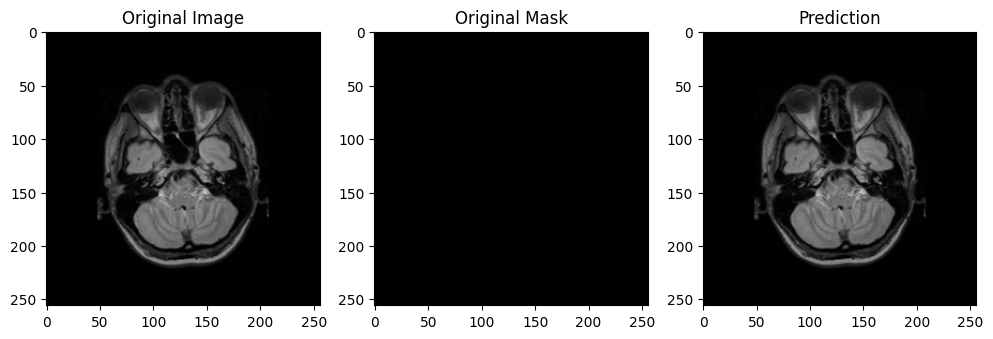


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23.tif: 256x256 (no detections), 35.8ms
Speed: 0.6ms preprocess, 35.8ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


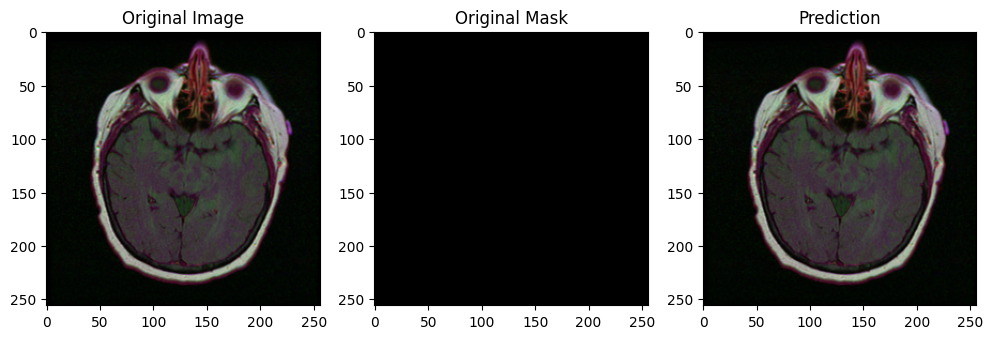


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_40.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.6ms preprocess, 35.5ms inference, 3.3ms postprocess per image at shape (1, 3, 256, 256)


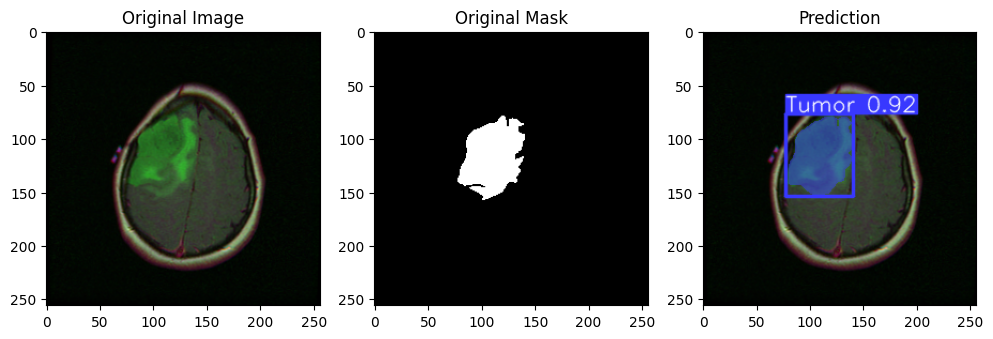


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_27.tif: 256x256 1 Tumor, 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


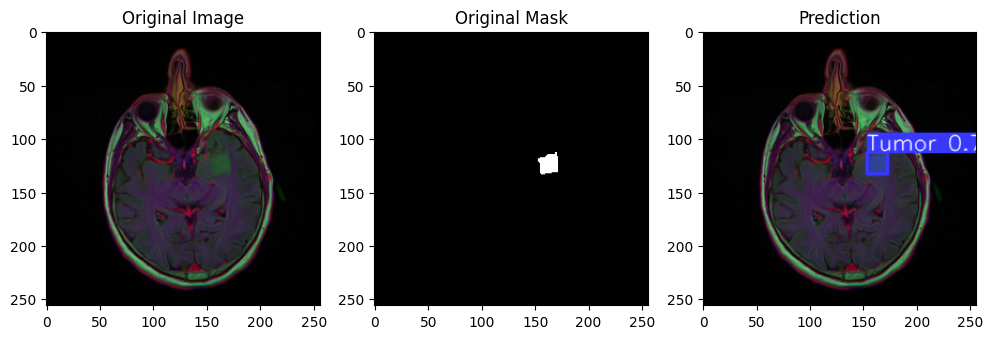


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif: 256x256 (no detections), 36.1ms
Speed: 0.8ms preprocess, 36.1ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


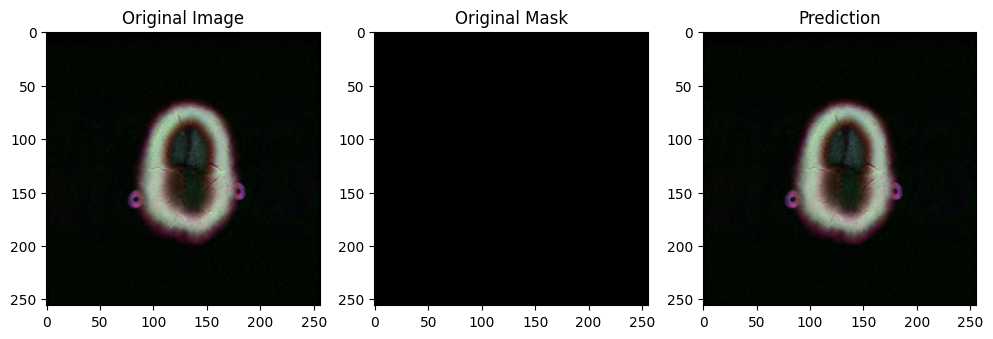


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_8.tif: 256x256 (no detections), 36.3ms
Speed: 0.8ms preprocess, 36.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


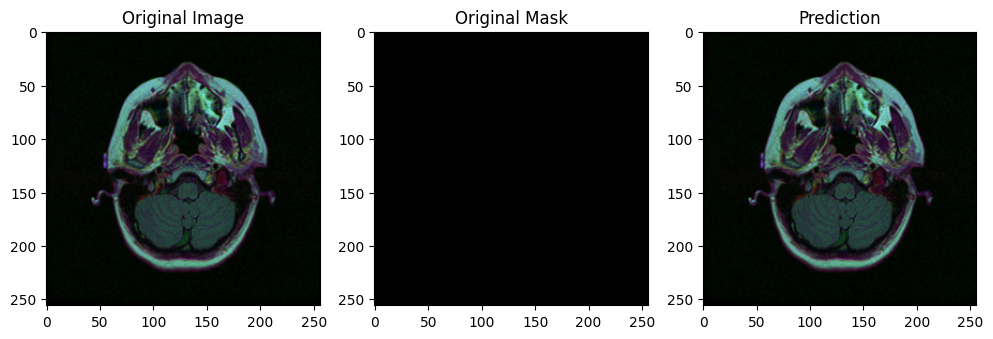


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19.tif: 256x256 (no detections), 35.6ms
Speed: 0.8ms preprocess, 35.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


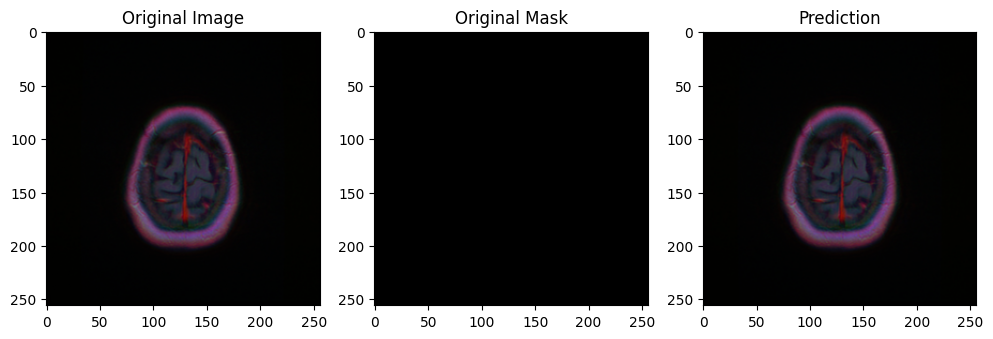


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.6ms preprocess, 35.5ms inference, 3.4ms postprocess per image at shape (1, 3, 256, 256)


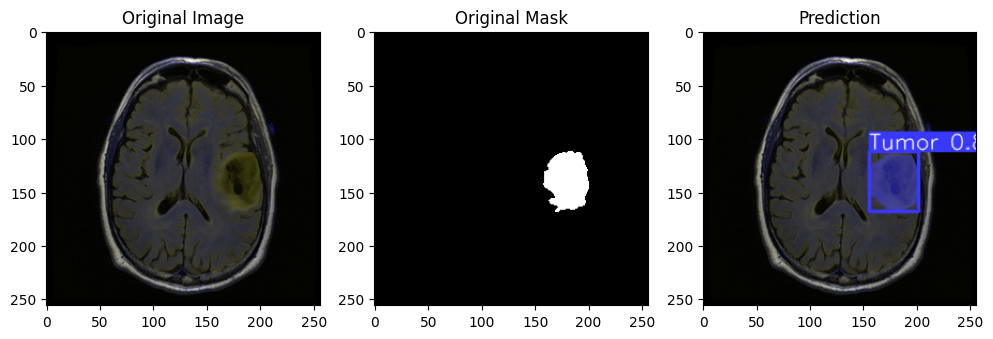


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_4.tif: 256x256 (no detections), 35.7ms
Speed: 0.6ms preprocess, 35.7ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


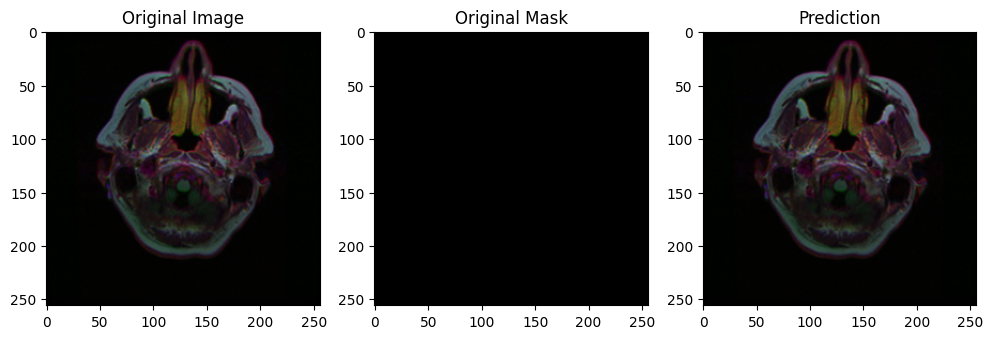


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_5.tif: 256x256 (no detections), 35.3ms
Speed: 0.8ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


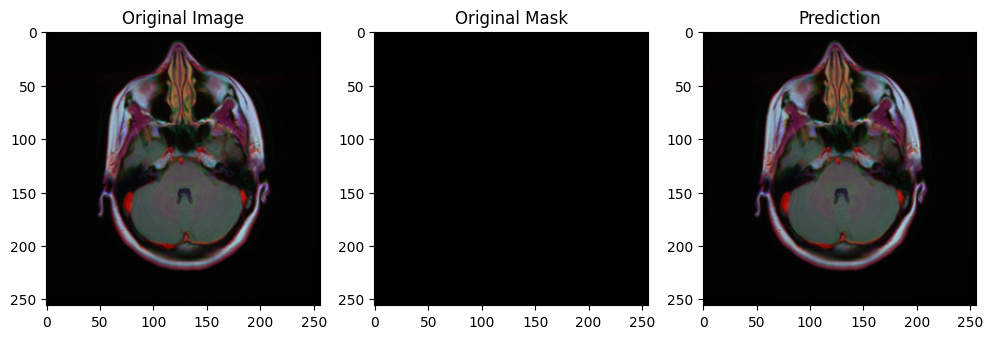


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_26.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.6ms preprocess, 35.5ms inference, 3.4ms postprocess per image at shape (1, 3, 256, 256)


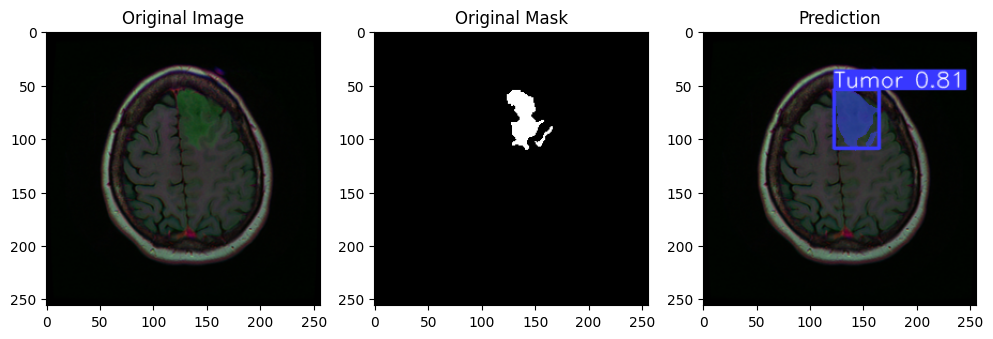


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_10.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


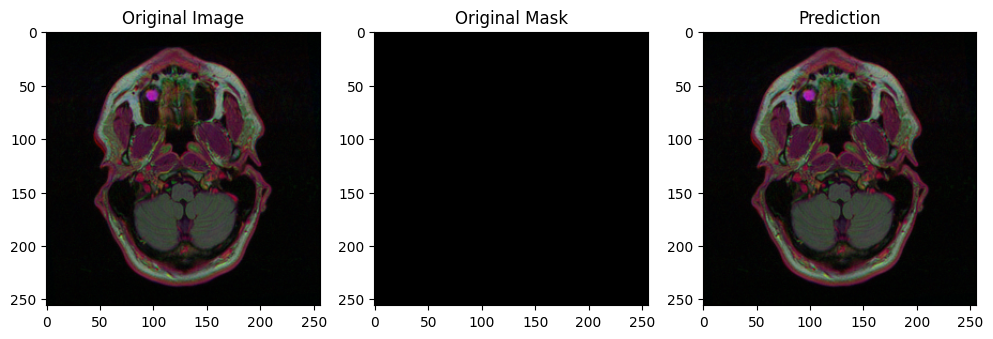


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_7.tif: 256x256 (no detections), 35.6ms
Speed: 0.6ms preprocess, 35.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


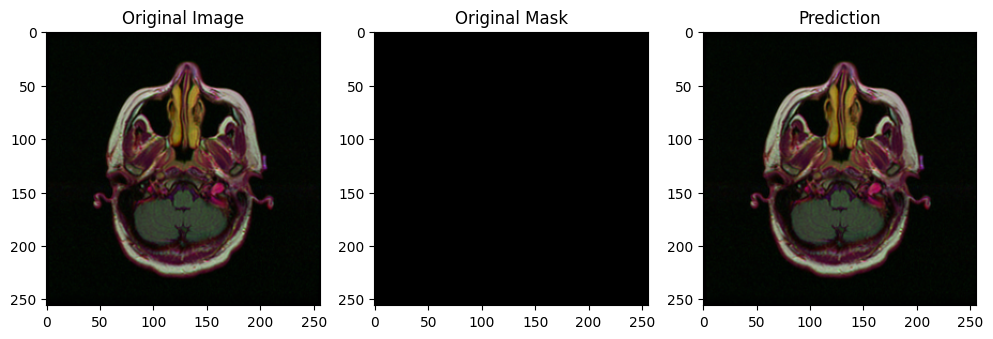

In [34]:
im_height =256
im_width =256
for i in range(100, 120):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    
    pred=model.predict(df_test['image_path'].iloc[index])
    
    path_im_pred = pred[0].path
    name = path_im_pred.split("/")[6]
    path_im_pred = "/kaggle/working/runs/segment/train2/" + name 
    im = cv2.imread(path_im_pred)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(im)
    plt.title('Prediction')
    plt.show()